# ⭐ DWthon 8.0. Сделать прогноз - будет ли пациент с диабетом направлен в больницу в течение 30 дней ⭐



 🏥 Медицина развивается (по крайней мере, пытается), и существуют различные программы, направленные на это. Сейчас мы коснемся темы лечения ([гипергликемии](https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D0%BF%D0%B5%D1%80%D0%B3%D0%BB%D0%B8%D0%BA%D0%B5%D0%BC%D0%B8%D1%8F)). Например, в США существует такая программа [Hospital Readmission Reduction Program (HRRP)](https://www.cms.gov/Medicare/Quality-Initiatives-Patient-Assessment-Instruments/Value-Based-Programs/HRRP/Hospital-Readmission-Reduction-Program.html) - *(в переводе на русский - программа сокращения повторных госпитализаций)*, с помощью которой пробуют минимизировать возмещение больницам с показателями реадмиссии (повторных госпитализаций) выше среднего. 

Для тех больниц, которые в настоящее время наказываются в рамках этой программы, одним из решений является создание интервенции для оказания дополнительной помощи пациентам с повышенным риском реадмиссии. Вопрос, однако, заключается в том, как выявить таких пациентов? Здесь на помощь может прийти машинное обучение. 


### 💉💊 Что такое диабет?
Диабет – это хроническое заболевание, которое возникает либо в случаях, когда поджелудочная железа не вырабатывает достаточное количество инсулина, либо когда организм не может эффективно использовать вырабатываемый инсулин. Инсулин – это гормон, регулирующий уровень глюкозы в крови. Распространенным следствием неконтролируемого диабета является гипергликемия, или повышенный уровень содержания глюкозы (сахара) в крови, со временем приводящая к серьезному повреждению многих систем организма, особенно нервов и кровеносных сосудов.

###  👩‍⚕️👨‍⚕️⚕️Цель 
Наша цель - предсказать, будет ли пациент с диабетом направлен в больницу в течение 30 дней, т.е. предсказать значение для столбца `readmitted`. Метрикой качества будет **F1.5**.

### 🏆 Kaggle
Конкурс на Kaggle - ссылка на [соревнование]( https://www.kaggle.com/t/0dcd1f5e99fa4cd98db2451e636de318).

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as ctb
import eli5
from scikitplot.estimators import plot_learning_curve
from tqdm import tqdm

In [2]:
#загружаем данные
train = pd.read_hdf('diabetic_train.h5')
test = pd.read_hdf('diabetic_test.h5')

In [3]:
#объединяем train и test в один dataframe чтобы делать совместные преобразования
df = pd.concat([train, test], sort=False)
df.fillna(-1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66221 entries, 0 to 101764
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              66221 non-null  int32 
 1   patient_nbr               66221 non-null  int32 
 2   race                      66221 non-null  object
 3   gender                    66221 non-null  object
 4   age                       66221 non-null  object
 5   weight                    66221 non-null  object
 6   admission_type_id         66221 non-null  int8  
 7   discharge_disposition_id  66221 non-null  int8  
 8   admission_source_id       66221 non-null  int8  
 9   time_in_hospital          66221 non-null  int8  
 10  payer_code                66221 non-null  object
 11  medical_specialty         66221 non-null  object
 12  num_lab_procedures        66221 non-null  int16 
 13  num_procedures            66221 non-null  int8  
 14  num_medications      

### Описание данных

- **encounter_id** - Уникальный идентификатор посещения
- **patient_nbr** - Уникальный идентификатор пациента
- **race** - Раса
- **gender** - Пол
- **age** - Возрастные группы с интервалом в 10 лет
- **weight** - Вес в фунтах
- **admission_type_id** - Цифровой идентификатор типа госпитализации (например, "экстренная", "новорожденный" и т.д.).
- **discharge_disposition_id** - Цифровой идентификатор типа выписки из больницы (например, "просроченная", "выписана домой" и т.д.).
- **admission_source_id** - Цифровой идентификатор источника посещения (например, "перевод из другой больницы", "направление от врача" и т.д.).
- **time_in_hospital** - Время пребывания в больнице в днях
- **payer_code** - Идентификатор типа оплаты (например, оплачивал ли пациент самостоятельно лечение или по страховке Blue Cross/Blue Shield и т.д.).
- **medical_specialty** - Специальность врача, принявшего пациента
- **num_lab_procedures** - Количество лабораторных исследований, проведенных во время посещения
- **num_procedures** - Количество процедур (кроме лабораторных исследований), проведенных во время посещения
- **num_medications** - Количество уникальных лекарств, назначенных во время посещения
- **number_outpatient** - Количество амбулаторных посещений пациента в течение года, предшествующего приему у врача
- **number_emergency** - Количество посещений пациентами неотложной помощи (англ. emergency) в течение года, предшествующего приему
- **number_inpatient** - Количество посещений госпитализированных пациентов в течение года, предшествующего назначению на должность
- **diag_1** - Основной диагноз (указывается в виде первых 3 цифр в соответствии со стандартом ICD9)
- **diag_2** - Вторичный диагноз (указывается в виде первых 3 цифр в соответствии со стандартом ICD9)
- **diag_3** - Дополнительный вторичный диагноз (указывается в виде первых 3 цифр в соответствии со стандартом ICD9)
- **number_diagnoses** - Количество диагнозов, введенных в систему
- **max_glu_serum** - Результат теста на глюкозу
- **A1Cresult** - Результат теста A1c. ">8", если результат был больше 8%, ">7", если результат был больше 7%, но меньше 8%. "нормально", если результат менее 7%.
- **change** - Информация о том, были ли изменения в приеме лекарств (как доза, так и тип лекарства)
- **diabetesMed** - Информация о наличии рецепта на какие-либо лекарства от диабета
- 24 колонки с названиями лекарств (**метформин, репаглинид, натеглинид, хлорпропамид, глимепирид, ацетогексамид, глипизид, глибурид, толбутамид, пиоглитазон, росиглитазон, акарбоза, миглитол, троглитазон, толазамид, экзамид, ситаглиптин, инсулин, глибурид-метформин, глипизид-метформин, глимепирид-пиоглитазон, метформин-росиглитазон, метформин-пиоглитазон**) - Сообщает, была ли увеличена, уменьшена или осталась прежней доза лекарства, или лекарство вообще не назначалось. `('No': 0, 'Steady': 1, 'Up': 2, 'Down': 3)`
- **readmitted** - Был ли пациент повторно госпитализирован в течение 30 дней
- **id** - Уникальный идентификатор наблюдения (необходим для Kaggle)

In [5]:
df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id
939,7205370,10152693,Asian,Male,[50-60),?,3,1,1,8,...,3,0,0,0,0,0,True,True,,939
70243,201243252,94992426,Caucasian,Female,[90-100),?,2,3,7,2,...,3,0,0,0,0,0,True,True,0,70243
68878,195039528,59152221,Hispanic,Male,[20-30),?,1,1,7,4,...,3,0,0,0,0,0,True,True,0,68878
15404,59166990,652626,AfricanAmerican,Female,[40-50),?,3,1,1,1,...,1,0,0,0,0,0,False,True,,15404
5565,28748322,4778442,AfricanAmerican,Female,[70-80),?,6,1,7,1,...,1,0,0,0,0,0,False,True,,5565


/var/folders/y0/kw229md554vdy3lj74nqgmdm0000gn/T/ipykernel_29424/1675022930.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

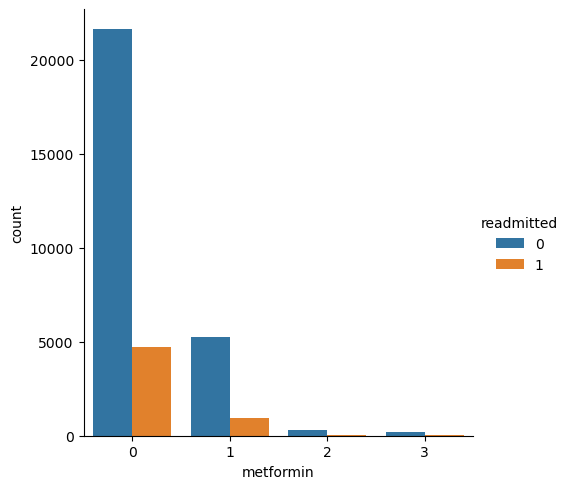

<Figure size 1000x500 with 0 Axes>

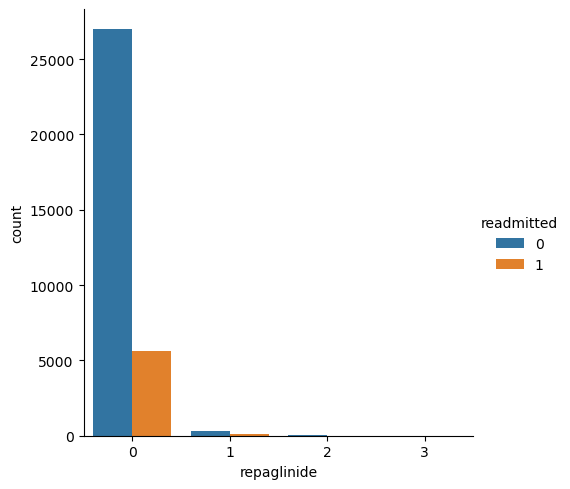

<Figure size 1000x500 with 0 Axes>

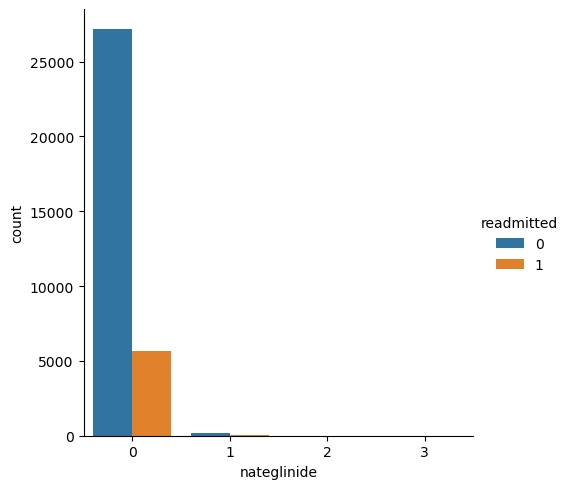

<Figure size 1000x500 with 0 Axes>

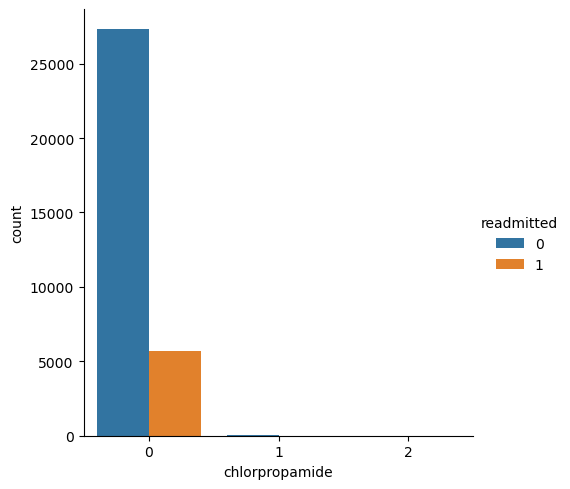

<Figure size 1000x500 with 0 Axes>

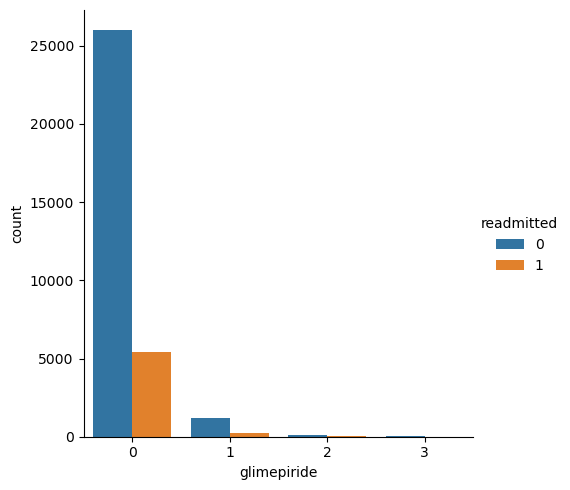

<Figure size 1000x500 with 0 Axes>

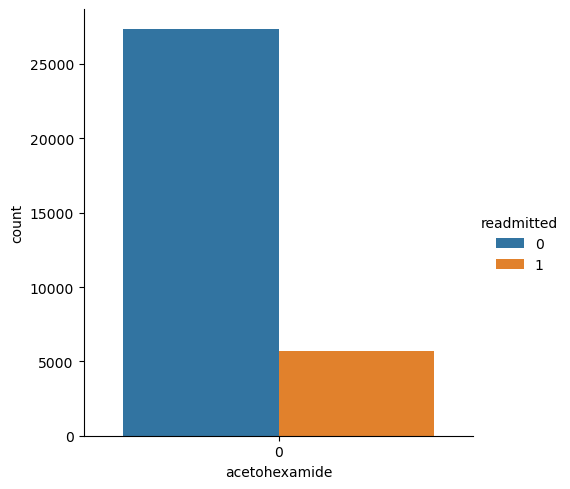

<Figure size 1000x500 with 0 Axes>

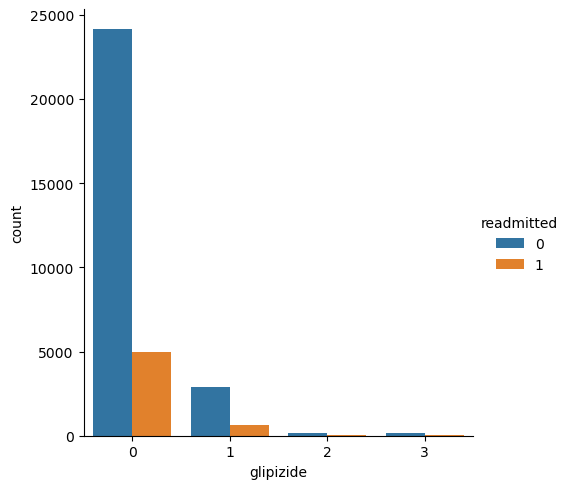

<Figure size 1000x500 with 0 Axes>

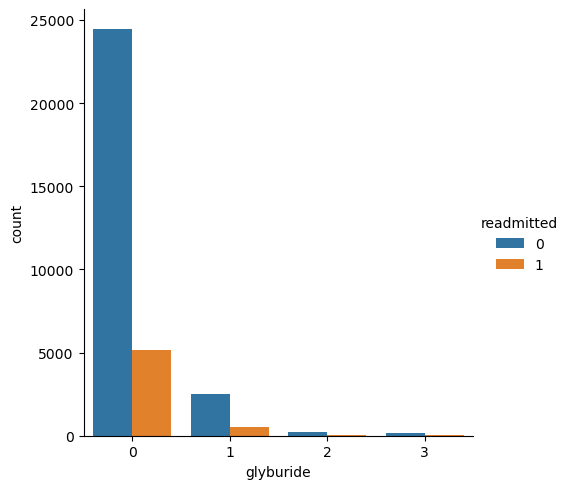

<Figure size 1000x500 with 0 Axes>

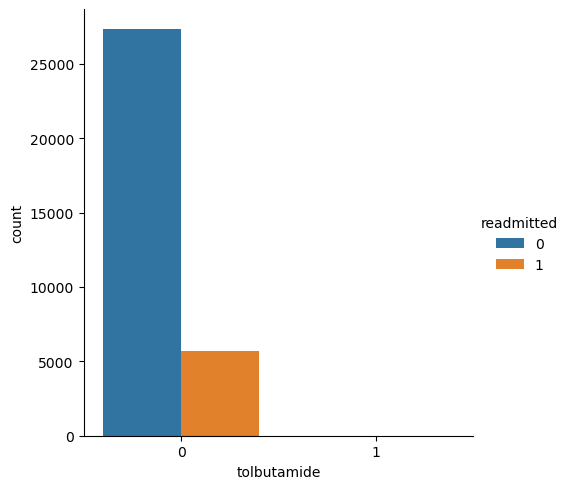

<Figure size 1000x500 with 0 Axes>

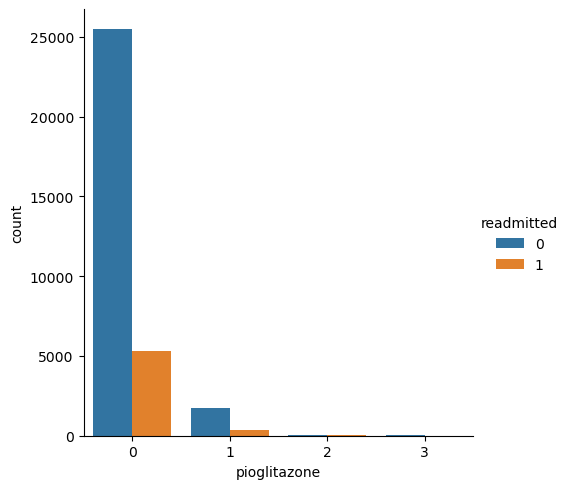

<Figure size 1000x500 with 0 Axes>

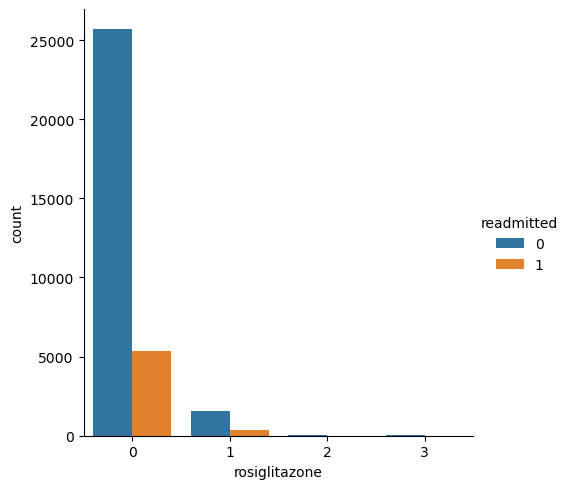

<Figure size 1000x500 with 0 Axes>

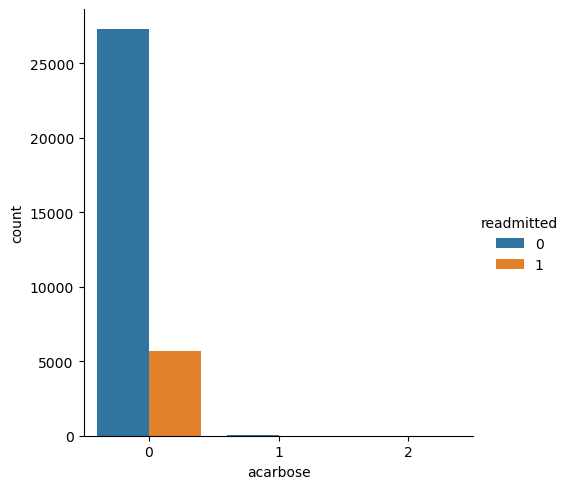

<Figure size 1000x500 with 0 Axes>

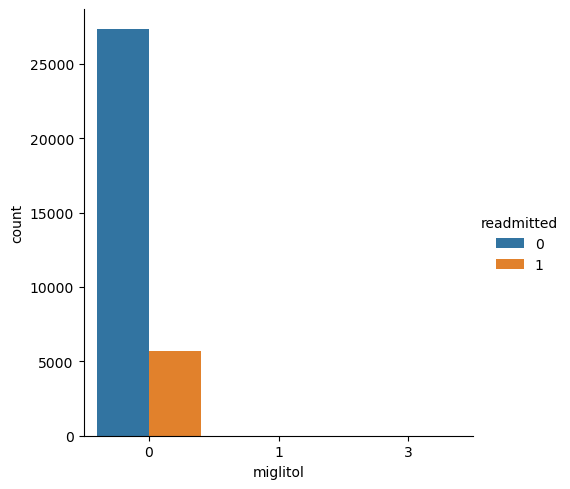

<Figure size 1000x500 with 0 Axes>

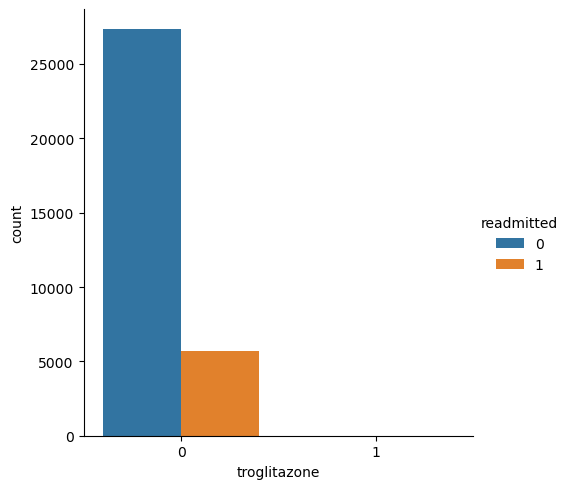

<Figure size 1000x500 with 0 Axes>

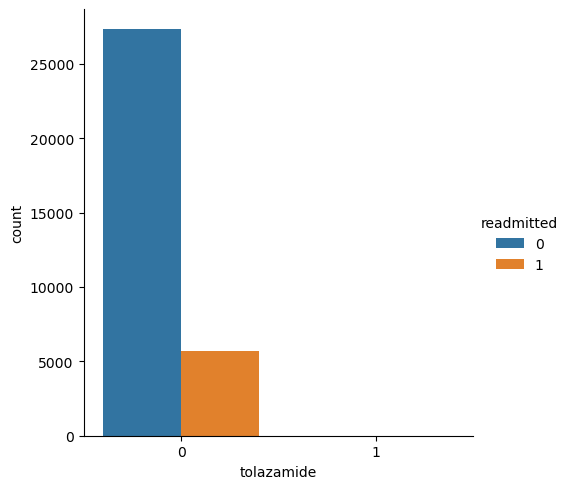

<Figure size 1000x500 with 0 Axes>

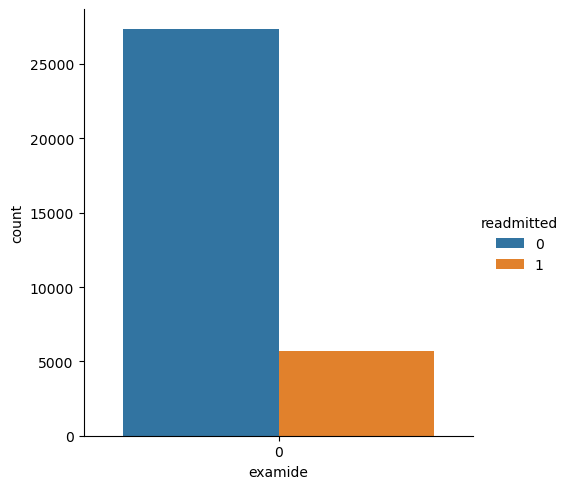

<Figure size 1000x500 with 0 Axes>

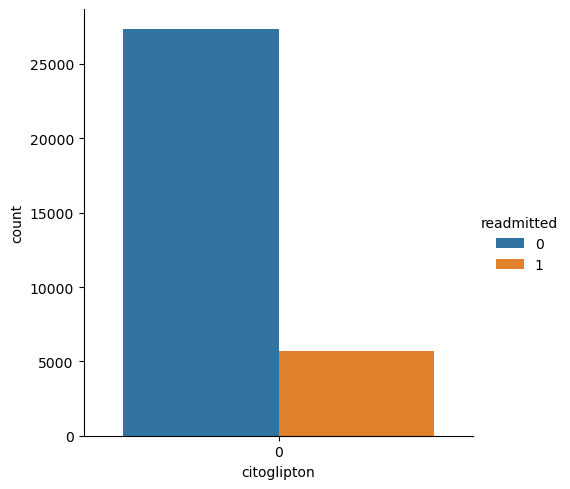

<Figure size 1000x500 with 0 Axes>

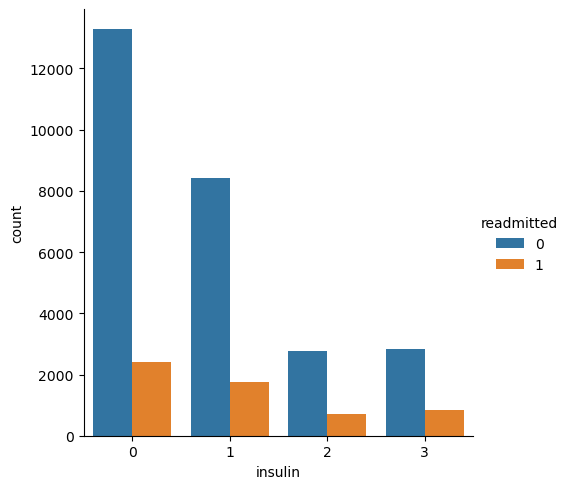

<Figure size 1000x500 with 0 Axes>

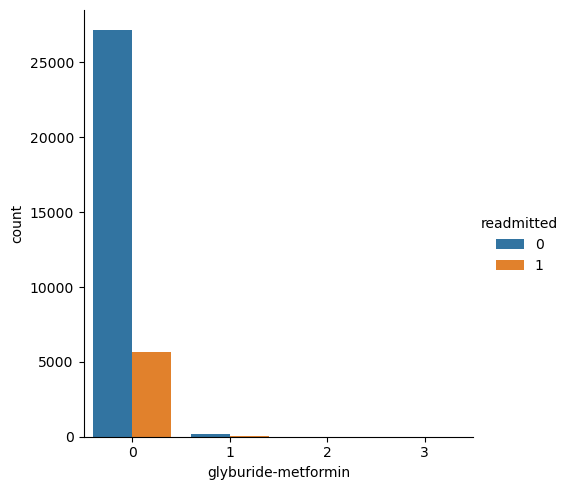

<Figure size 1000x500 with 0 Axes>

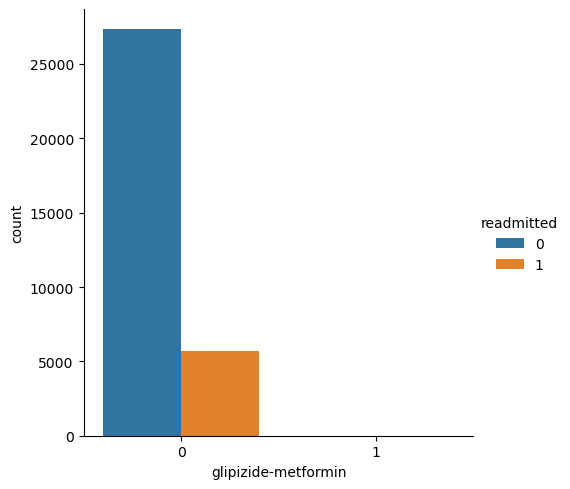

<Figure size 1000x500 with 0 Axes>

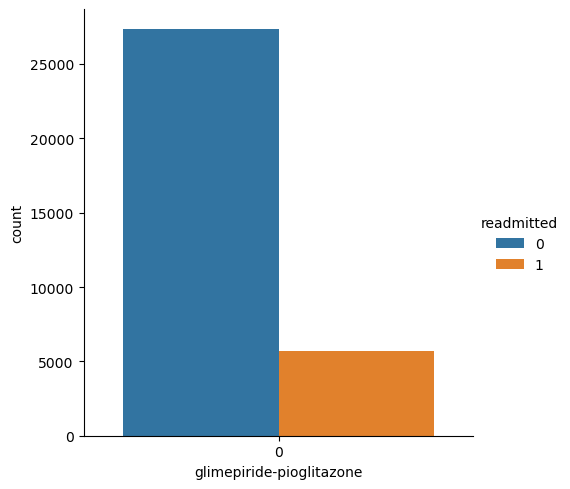

<Figure size 1000x500 with 0 Axes>

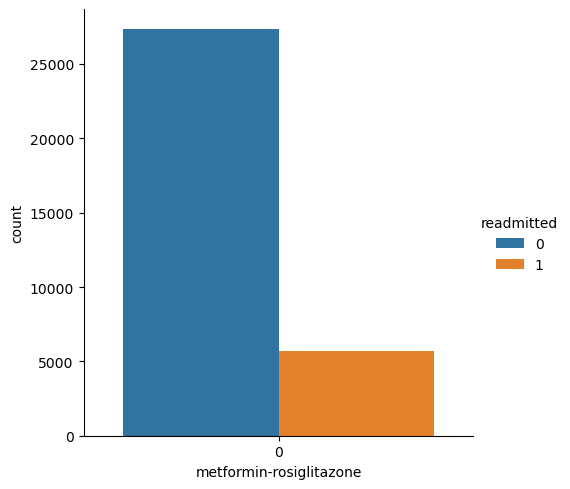

<Figure size 1000x500 with 0 Axes>

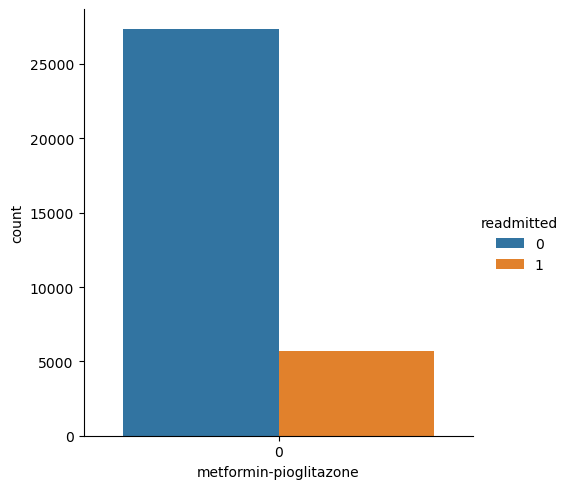

In [6]:
#графики лекарств визуализируем по train
medicaments = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
for medicament in medicaments:
    plt.figure(figsize=(10, 5))
    sns.catplot(x=medicament, hue='readmitted', data=train, kind="count")

In [7]:
df['race'] = df['race'].replace('?','Unknown')
df['payer_code'] = df['payer_code'].replace('?','Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?','Unknown')
df['weight'] = df['weight'].replace('?','Unknown')

In [8]:
# у max_glu_serum отсутствует 94,85% данных, но попробуем их использовать
df['max_glu_serum']=df['max_glu_serum'].map({'None':0,'Norm':100,'>200':200,'>300':300})
df['A1Cresult']=df['A1Cresult'].map({'None':0,'Norm':5,'>7':7,'>8':8})

In [9]:
#удаляем неизвестные данные из общего df (так как они относятся к train)
df = df[df.gender != 'Unknown/Invalid']

In [10]:
age_id = {'[0-10)': 0, 
          '[10-20)': 1, 
          '[20-30)': 2, 
          '[30-40)': 3, 
          '[40-50)': 4, 
          '[50-60)': 5,
          '[60-70)': 6, 
          '[70-80)': 7, 
          '[80-90)': 8, 
          '[90-100)': 9}
df['age'] = df.age.replace(age_id)

In [11]:
df['diag_1'].value_counts().head(20) 
#тут представлены коды болезни по МКБ-9, попробуем их преобразовать

414      4455
428      3773
786      2598
410      2549
486      2139
427      1792
715      1583
434      1440
780      1289
682      1268
491      1202
996      1196
276      1176
38       1134
584       996
250.8     978
599       978
820       785
V57       782
518       748
Name: diag_1, dtype: int64

**Ниже приведен список кодов Международной статистической классификации болезней и связанных с ними проблем со здоровьем***

1 - Список кодов МКБ-9 001-139: инфекционные и паразитарные заболевания,   
2 - Список кодов МКБ-9 140-239: новообразования,    
3 - Список кодов МКБ-9 240-279: эндокринные, пищевые и метаболические заболевания и нарушения иммунитета,  
4 - Список кодов МКБ-9 280-289: болезни крови и кроветворных органов,  
5 - Список кодов МКБ-9 290-319: психические расстройства,   
6 - Список кодов МКБ-9 320-389: болезни нервной системы и органов чувств,  
7 - Список кодов МКБ-9 390-459: болезни системы кровообращения,  
8 - Список кодов МКБ-9 460-519: болезни дыхательной системы,  
9 - Список кодов МКБ-9 520-579: болезни пищеварительной системы,  
10 - Список кодов МКБ-9 580-629: болезни мочеполовой системы,  
11 - Список кодов МКБ-9 630-679: осложнения беременности, родов и послеродового периода,  
12 - Список кодов МКБ-9 680-709: заболевания кожи и подкожной клетчатки,  
13 - Список кодов МКБ-9 710-739: заболевания опорно-двигательного аппарата и соединительной ткани,  
14 - Список кодов МКБ-9 740-759: врожденные аномалии,  
15 - Список кодов МКБ-9 760-779: определенные состояния, возникающие в перинатальный период,  
16 - Список кодов МКБ-9 780-799: симптомы, признаки и неопределенные состояния,  
17 - Список кодов МКБ-9 800-999: травмы и отравления,  
18 - Список кодов МКБ-9 E и V коды: внешние причины травм и дополнительная классификация  

250 - по МКБ-9 это диабет (сахарный диабет)

In [12]:
df['diag_1'] = df['diag_1'].replace('?','0')
df['diag_2'] = df['diag_2'].replace('?','0')
df['diag_3'] = df['diag_3'].replace('?','0')

In [13]:
#сделаем отдельно столбцы для диабета по МБК250 для диабета
df['diag_1_diabet'] = (df['diag_1'].str.contains('250')).astype(int)
df['diag_2_diabet'] = (df['diag_2'].str.contains('250')).astype(int)
df['diag_3_diabet'] = (df['diag_3'].str.contains('250')).astype(int)

In [14]:
df['diag_1'] = df['diag_1'].apply(lambda x: 18 if (str(x).find('V') != -1 or str(x).find('E') != -1) 
                                   else ( 1 if int(float(x)) in range(1, 140) 
                                   else ( 2 if int(float(x)) in range(140, 240) 
                                    else ( 3 if int(float(x)) in range(280, 290) 
                                    else ( 4 if int(float(x)) in range(290, 320) 
                                    else ( 5 if int(float(x)) in range(320, 390) 
                                    else ( 6 if int(float(x)) in range(390, 460) 
                                    else ( 7 if int(float(x)) in range(460, 520) 
                                    else ( 8 if int(float(x)) in range(520, 580) 
                                    else ( 9 if int(float(x)) in range(580, 630) 
                                    else ( 10 if int(float(x)) in range(630, 680) 
                                    else ( 11 if int(float(x)) in range(680, 710) 
                                    else ( 12 if int(float(x)) in range(710, 740) 
                                    else ( 13 if int(float(x)) in range(740, 760) 
                                    else ( 14 if int(float(x)) in range(760, 780) 
                                    else ( 15 if int(float(x)) in range(780, 800) 
                                    else ( 16 if int(float(x)) in range(800, 1000) 
                                    else 17
                                            )))))))))))))))))

In [15]:
df['diag_2'] = df['diag_2'].apply(lambda x: 18 if (str(x).find('V') != -1 or str(x).find('E') != -1) 
                                   else ( 1 if int(float(x)) in range(1, 140) 
                                   else ( 2 if int(float(x)) in range(140, 240) 
                                    else ( 3 if int(float(x)) in range(280, 290) 
                                    else ( 4 if int(float(x)) in range(290, 320) 
                                    else ( 5 if int(float(x)) in range(320, 390) 
                                    else ( 6 if int(float(x)) in range(390, 460) 
                                    else ( 7 if int(float(x)) in range(460, 520) 
                                    else ( 8 if int(float(x)) in range(520, 580) 
                                    else ( 9 if int(float(x)) in range(580, 630) 
                                    else ( 10 if int(float(x)) in range(630, 680) 
                                    else ( 11 if int(float(x)) in range(680, 710) 
                                    else ( 12 if int(float(x)) in range(710, 740) 
                                    else ( 13 if int(float(x)) in range(740, 760) 
                                    else ( 14 if int(float(x)) in range(760, 780) 
                                    else ( 15 if int(float(x)) in range(780, 800) 
                                    else ( 16 if int(float(x)) in range(800, 1000) 
                                    else 17
                                            )))))))))))))))))

In [16]:
df['diag_3'] = df['diag_3'].apply(lambda x: 18 if (str(x).find('V') != -1 or str(x).find('E') != -1) 
                                   else ( 1 if int(float(x)) in range(1, 140) 
                                   else ( 2 if int(float(x)) in range(140, 240) 
                                    else ( 3 if int(float(x)) in range(280, 290) 
                                    else ( 4 if int(float(x)) in range(290, 320) 
                                    else ( 5 if int(float(x)) in range(320, 390) 
                                    else ( 6 if int(float(x)) in range(390, 460) 
                                    else ( 7 if int(float(x)) in range(460, 520) 
                                    else ( 8 if int(float(x)) in range(520, 580) 
                                    else ( 9 if int(float(x)) in range(580, 630) 
                                    else ( 10 if int(float(x)) in range(630, 680) 
                                    else ( 11 if int(float(x)) in range(680, 710) 
                                    else ( 12 if int(float(x)) in range(710, 740) 
                                    else ( 13 if int(float(x)) in range(740, 760) 
                                    else ( 14 if int(float(x)) in range(760, 780) 
                                    else ( 15 if int(float(x)) in range(780, 800) 
                                    else ( 16 if int(float(x)) in range(800, 1000) 
                                    else 17
                                            )))))))))))))))))

In [17]:
df.select_dtypes(include=[object, bool]).columns

Index(['race', 'gender', 'weight', 'payer_code', 'medical_specialty', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [18]:
cat_features = df.select_dtypes(include=[object, bool]).columns 

def feature_engineering(df, cat_features):
    for feature in cat_features:
        df['{}_cat'.format(feature)] = df[feature].factorize()[0] 
    return df

df = feature_engineering(df.copy(), cat_features)

/var/folders/y0/kw229md554vdy3lj74nqgmdm0000gn/T/ipykernel_29424/1702526109.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().round(2),


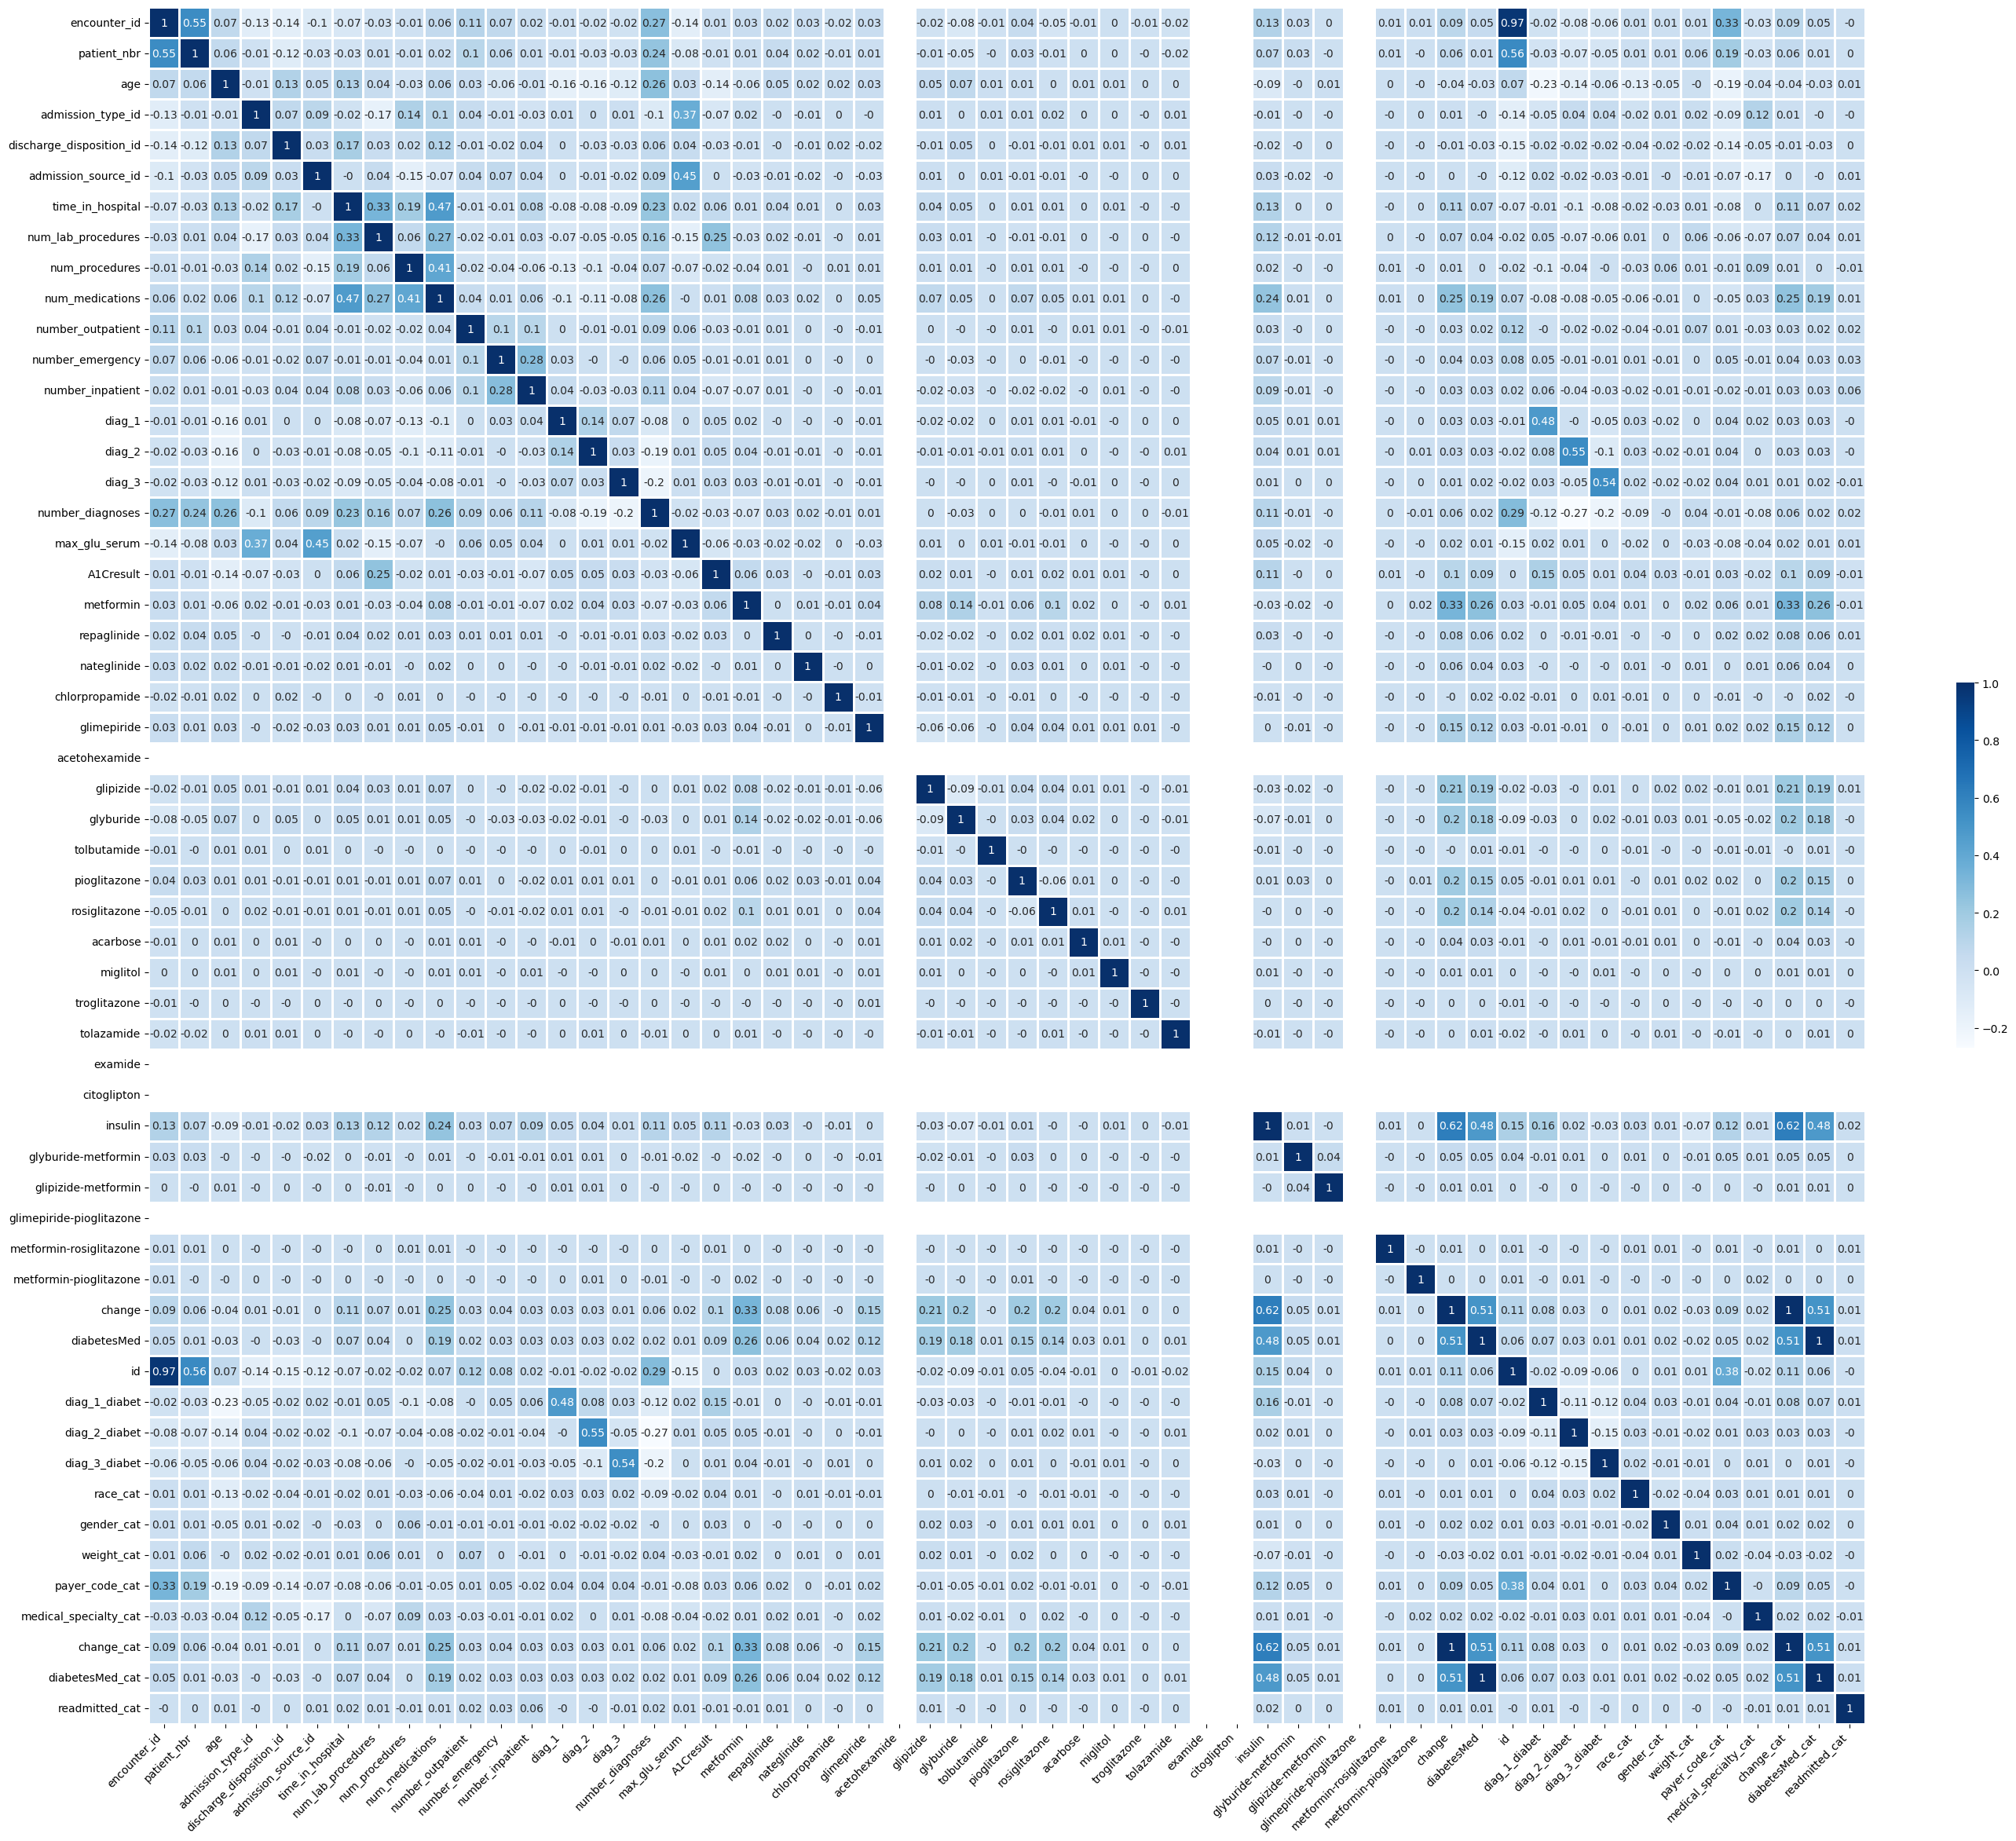

In [19]:
plt.rcParams["figure.figsize"] = (30, 30)
heatmap = sns.heatmap(
    df.corr().round(2),
    annot=True,
    square=True,
    
    cmap="Blues",  
    cbar_kws={"fraction": 0.01}, 
    linewidth=2, 
)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right");

In [20]:
#создаем новые признаки
df["metformin_change"] = df["metformin"].astype(str) +"_"+df["change"].astype(str)
df["insulin_change"] = df["insulin"].astype(str) +"_"+df["change"].astype(str)
df["diabetesMed_change"] = df["diabetesMed"].astype(str) +"_"+df["change"].astype(str)
df["num_medications_change"] = df["num_medications"].astype(str) +"_"+df["change"].astype(str)
df["insulin_diabetesMed"] = df["insulin"].astype(str) +"_"+df["diabetesMed"].astype(str)
df["num_medications_diabetesMed"] = df["num_medications"].astype(str) +"_"+df["diabetesMed"].astype(str)
df["metformin_diabetesMed"] = df["metformin"].astype(str) +"_"+df["diabetesMed"].astype(str)
df["insulin_num_medications"] = df["insulin"].astype(str) +"_"+df["num_medications"].astype(str)
df["time_in_hospital_num_medications"] = df["time_in_hospital"].astype(str) +"_"+df["num_medications"].astype(str)
df["num_procedures_num_medications"] = df["num_procedures"].astype(str) +"_"+df["num_medications"].astype(str)
df["num_lab_procedures_num_medications"] = df["num_lab_procedures"].astype(str) +"_"+df["num_medications"].astype(str)
df["number_diagnoses_num_medications"] = df["number_diagnoses"].astype(str) +"_"+df["num_medications"].astype(str)
df["time_in_hospital_payer_code"] = df["time_in_hospital"].astype(str) +"_"+df["payer_code"].astype(str)
df["race_age"] = df["race"].astype(str) +"_"+df["age"].astype(str)
df["age_weight"] = df["age"].astype(str) +"_"+df["weight"].astype(str)
df["age_gender"] = df["age"].astype(str) +"_"+df["gender"].astype(str)

In [21]:
df.nunique() 
# сразу бросилось в глаза, что уникальных значений patient_nbr меньше чем значений id или encounter_id, 
# значит некоторые пациенты обращались по заболеванию повторно

encounter_id                        66218
patient_nbr                         59091
race                                    6
gender                                  2
age                                    10
                                    ...  
number_diagnoses_num_medications      537
time_in_hospital_payer_code           227
race_age                               60
age_weight                             64
age_gender                             20
Length: 78, dtype: int64

In [22]:
#используем cumsum
df["temp"] = 1
df["cumsum"] = df.sort_values(by='encounter_id').groupby(by=['patient_nbr'])['temp'].transform(lambda x: x.cumsum())
df["cumsum_change"] = df.sort_values(by='encounter_id').groupby(by=['patient_nbr'])['change'].transform(lambda x: x.cumsum())
df["cumsum_diabetesMed"] = df.sort_values(by='encounter_id').groupby(by=['patient_nbr'])['diabetesMed_cat'].transform(lambda x: x.cumsum())
df["%_of_changes"] = df["cumsum_change"]/df["cumsum"]

In [23]:
#среднее от value of time in hospital/ number diagnoses
t_pivot = df.pivot_table(values=["time_in_hospital", "number_diagnoses", "num_medications", "num_procedures", "num_lab_procedures", "number_outpatient", "number_inpatient", "number_emergency"], index=["patient_nbr"], aggfunc=np.mean).reset_index()
t_pivot.columns = ['patient_nbr', 'mean_number_diagnoses', 'mean_time_in_hospital', 'mean_num_medications', 'mean_num_procedures', 'mean_num_lab_procedures', 'mean_number_outpatient', 'mean_number_inpatient', 'mean_number_emergency']
df = pd.merge(df, t_pivot, on="patient_nbr", how="left")

In [24]:
#A1Cresult 
t2 = df.pivot_table(index='patient_nbr', columns='A1Cresult', values='id', aggfunc='count').fillna(0).reset_index()
t2.columns = ['patient_nbr', 'pA1Cresult_0', 'pA1Cresult_5', 'pA1Cresult_7', 'pA1Cresult_8']
df = pd.merge(df, t2, on="patient_nbr", how="left")

In [25]:
#max_glu_serum
t3 = df.pivot_table(index='patient_nbr', columns='max_glu_serum', values='id', aggfunc='count').fillna(0).reset_index()
t3.columns = ['patient_nbr', 'max_glu_serum_0', 'max_glu_serum_100', 'max_glu_serum_200', 'max_glu_serum_300']
df = pd.merge(df, t3, on="patient_nbr", how="left")

In [26]:
df_discharge_disposition_id = pd.get_dummies( df['discharge_disposition_id'],prefix='discharge_disposition_id' )
df_admission_source_id = pd.get_dummies( df['admission_source_id'],prefix='admission_source_id' )

df = pd.concat([df, df_discharge_disposition_id, df_admission_source_id], axis=1)

In [27]:
# df.payer_code_change.value_counts()
df.fillna(0)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25
0,2278392,8222157,Caucasian,Female,0,Unknown,6,25,1,1,...,0,0,0,0,0,0,0,0,0,0
1,64410,86047875,AfricanAmerican,Female,2,Unknown,1,1,7,2,...,0,0,0,0,0,0,0,0,0,0
2,500364,82442376,Caucasian,Male,3,Unknown,1,1,7,2,...,0,0,0,0,0,0,0,0,0,0
3,16680,42519267,Caucasian,Male,4,Unknown,1,1,7,1,...,0,0,0,0,0,0,0,0,0,0
4,12522,48330783,Caucasian,Female,8,Unknown,2,1,4,13,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66213,443842136,181593374,Caucasian,Female,7,Unknown,1,1,7,5,...,0,0,0,0,0,0,0,0,0,0
66214,443842340,120975314,Caucasian,Female,8,Unknown,1,1,7,5,...,0,0,0,0,0,0,0,0,0,0
66215,443847782,74694222,AfricanAmerican,Female,8,Unknown,1,4,5,5,...,0,0,0,0,0,0,0,0,0,0
66216,443854148,41088789,Caucasian,Male,7,Unknown,1,1,7,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#вспомогательные фукции 
def get_feats(df, black_list=["readmitted", "readmitted_cat", "id", "temp"]):

    feats = df.select_dtypes("number").columns
    feats = [x for x in feats if x not in black_list]
    
    return feats


def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)

    X = df[feats].values
    y = df['readmitted'].values
    
    return X, y

In [29]:
def __f15_score(y, y_pred):
    return fbeta_score(y, y_pred, beta=1.5)

f15_score  = make_scorer(__f15_score, greater_is_better=True)

In [30]:
feats = get_feats(df)
len(feats)

115

In [31]:
#train
train = df[ df.readmitted != ''].fillna(0)
X_train = train[feats].values
y_train = train['readmitted'].values

#test
test = df[ df.readmitted == ''].fillna(0)
X_test = df[ df.readmitted == ''][feats].values

In [32]:
train.readmitted = train.readmitted.astype(int)

Вместо использования .predict( ), воспользуемся .predict_proba( ), где сами определяем значение отсечения, например, 0,2. Т.е все, что ниже 0.5, получает оценку отсечения 0 (т.е. не возвращается в больницу), все, что выше 0.5, получает оценку 1. В примере ниже мы хотим изменить это и сами установить значение отсечения, threshold.

In [67]:
model = ctb.CatBoostClassifier(max_depth=4,
                               n_estimators=300, 
                               learning_rate=0.199452, 
                               loss_function="MultiClass",
                               random_state=7575, 
                               verbose=False,
                               boosting_type="Plain", #тип бустинга, который используется при обучении
                               bootstrap_type="Bernoulli", #определяет метод сэмплинга весов объектов
                               subsample=0.5, #вероятность, по которой будет выбираться каждый объект для построения дерева
                               rsm=0.5, #аналогичен subsample, только используется для фичей, а не объектов
                               leaf_estimation_iterations=5, #количество итераций подсчета значений в листьях.
                               max_ctr_complexity=1, #длина перебора комбинаций фичей из данной выборки
                              )
                              
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7575)
threshold = 0.2
X, y = get_X_y(train)
scores = []
for train_idx, test_idx in tqdm(cv.split(X, y, groups=train["patient_nbr"])):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype("int8")
    
    score =  __f15_score(y_test, y_pred)
    scores.append(score)
    
np.mean(scores)

10it [00:22,  2.29s/it]


0.7389120938356428

In [63]:
clf = ctb.CatBoostClassifier(max_depth=4, 
                            iterations = 100,
                             random_state=7575,
                         )

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=10,
    use_best_model=True,
    early_stopping_rounds=50,
)

Learning rate set to 0.199452
0:	learn: 0.5189550	test: 0.5208210	best: 0.5208210 (0)	total: 5.1ms	remaining: 505ms
10:	learn: 0.2512835	test: 0.2557990	best: 0.2557990 (10)	total: 55.5ms	remaining: 449ms
20:	learn: 0.2318472	test: 0.2395008	best: 0.2395008 (20)	total: 105ms	remaining: 395ms
30:	learn: 0.2234127	test: 0.2311752	best: 0.2311752 (30)	total: 155ms	remaining: 345ms
40:	learn: 0.2191280	test: 0.2286393	best: 0.2286393 (40)	total: 208ms	remaining: 299ms
50:	learn: 0.2154756	test: 0.2250514	best: 0.2250514 (50)	total: 259ms	remaining: 249ms
60:	learn: 0.2117779	test: 0.2232321	best: 0.2232246 (59)	total: 307ms	remaining: 196ms
70:	learn: 0.2089927	test: 0.2223129	best: 0.2223129 (70)	total: 355ms	remaining: 145ms
80:	learn: 0.2057158	test: 0.2193355	best: 0.2193355 (80)	total: 404ms	remaining: 94.8ms
90:	learn: 0.2033808	test: 0.2190296	best: 0.2189055 (85)	total: 454ms	remaining: 44.9ms
99:	learn: 0.2015964	test: 0.2191020	best: 0.2189055 (85)	total: 497ms	remaining: 0us

be

In [73]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=1.5

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.261577, F-Score=0.741, Precision=0.797, Recall=0.719


In [74]:
model = ctb.CatBoostClassifier(max_depth=4,
                               n_estimators=300, 
                               learning_rate=0.199452, 
                               loss_function="MultiClass",
                               random_state=7575, 
                               verbose=False,
                               boosting_type="Plain", #тип бустинга, который используется при обучении
                               bootstrap_type="Bernoulli", #определяет метод сэмплинга весов объектов
                               subsample=0.5, #вероятность, по которой будет выбираться каждый объект для построения дерева
                               rsm=0.5, #аналогичен subsample, только используется для фичей, а не объектов
                               leaf_estimation_iterations=5, #количество итераций подсчета значений в листьях.
                               max_ctr_complexity=1, #длина перебора комбинаций фичей из данной выборки
                              )
                              
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7575)
threshold = 0.261577
X, y = get_X_y(train)
scores = []
for train_idx, test_idx in tqdm(cv.split(X, y, groups=train["patient_nbr"])):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype("int8")
    
    score =  __f15_score(y_test, y_pred)
    scores.append(score)
    
np.mean(scores)

10it [00:22,  2.28s/it]


0.7403092646026374

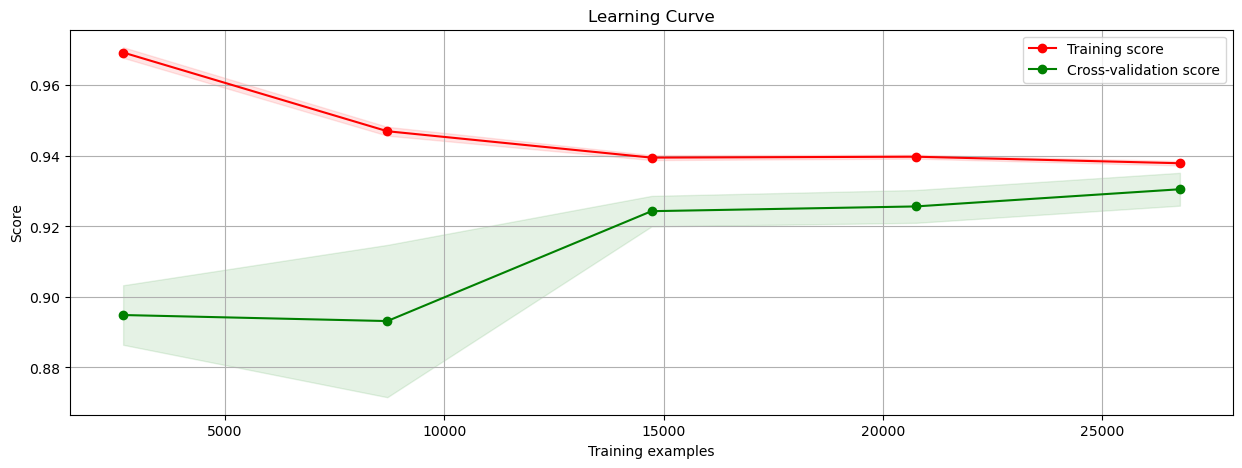

In [75]:
plt.rcParams["figure.figsize"] = (15, 5)
plot_learning_curve(ctb.CatBoostClassifier(max_depth=4, n_estimators=300, learning_rate=0.199452, loss_function="MultiClass", random_state=7575, verbose=False), X_train, y_train, cv=cv);

In [76]:
eli5.show_weights(model, feature_names=feats, top=110)

Weight,Feature
0.1897,max_glu_serum_0
0.1484,mean_number_outpatient
0.1216,cumsum
0.1144,number_inpatient
0.0902,pA1Cresult_0
0.0507,discharge_disposition_id_11
0.0429,patient_nbr
0.0402,encounter_id
0.0090,payer_code_cat
0.0087,num_lab_procedures


### Submit

In [77]:
threshold = 0.261577
feats = get_feats(train)

X_train, y_train = get_X_y(train, feats)
X_test = test[feats].values

model = ctb.CatBoostClassifier(max_depth=4,
                               n_estimators=300, 
                               learning_rate=0.199452, 
                               loss_function="MultiClass",
                               random_state=7575, 
                               verbose=False,
                               boosting_type="Plain",
                               bootstrap_type="Bernoulli",
                               subsample=0.5,
                               rsm=0.5,
                               leaf_estimation_iterations=5,
                               max_ctr_complexity=1,
                              )
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > threshold).astype("int8")

### Подготовка файла, который можно добавить на Kaggle 

In [78]:
test['readmitted'] = y_pred
test[['id', 'readmitted']].to_csv('submit_final_1.csv', index=False) 

### Результаты на Kaggle с доработкой после конкурса:  
Public Score: **0.74365**   
Private Score: **0.7519**   

![](submit_final_1.png)